In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin_cached_model as lcm
import pymc3 as pm
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
import scipy
import theano.tensor as tt

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # function evals   = 47
    # data points      = 1000
    # variables        = 2
    chi-square         = 1.119
    reduced chi-square = 0.001
    Akaike info crit   = -6789.298
    Bayesian info crit = -6779.482
[[Variables]]
    amplitude:   0.89084563 +/- 0.013662 (1.53%) (init= 0.05268735)
    decay:       21.9681067 +/- 0.487327 (2.22%) (init= 726.1693)
[[Correlations]] (unreported correlations are <  0.250)
    C(amplitude, decay)          = -0.691 



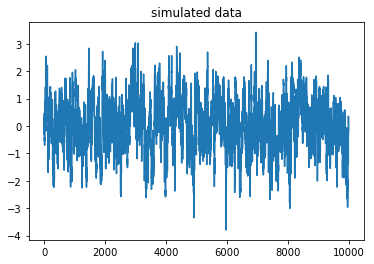

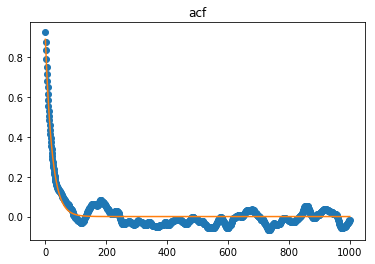

In [2]:
A,D = 1.0,1.0
delta_t=0.05
N=10000 # length of data set
P=1000 # range to fit acf

data = langevin.time_series(A=A,D=D,delta_t=delta_t,N=N)

plt.figure()
plt.plot(data)
plt.title('simulated data')

# calculate autocorrelation function
f = np.fft.rfft(data)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / N
autocorr=acf[int(N/2):]

y = autocorr[:min(int(N/2),P)]
t = np.arange(min(int(N/2),P))

mod=ExponentialModel()
pars = mod.guess(y, x=t)
out  = mod.fit(y, pars, x=t)
print(out.fit_report(min_correl=0.25))

plt.figure()
plt.plot(t,y,"o")
plt.plot(t,out.best_fit)
plt.title('acf')

In [3]:
sumsq = np.sum(data[1:-1]**2)
sumiplusone = np.sum(data[:-1]*data[1:])
print(sumsq,sumiplusone)

9266.41352913 8787.40388295


In [4]:
#calculate B_max
coef = [(N-1)*sumsq,
       (2.0-N)*sumiplusone,
       -data[0]**2-(N+1)*sumsq-N*data[-1]**2-data[-1]**2,
       N*sumiplusone]
f = np.poly1d(coef)

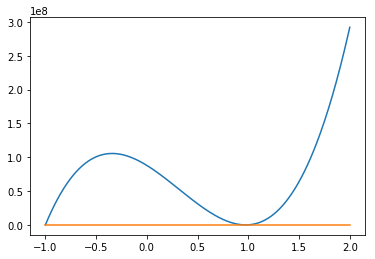

In [19]:
x=np.linspace(-1,2,301)
plt.plot(x,f(x))
plt.plot([-1,2],[0,0])

In [6]:
print(scipy.optimize.root(f,0.5))
print(np.roots(coef))

    fjac: array([[-1.]])
     fun: array([ -1.49011612e-08])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-0.00021628])
       r: array([ 9383983.9388182])
  status: 1
 success: True
       x: array([ 0.94816466])
[-1.00010131  1.00014871  0.94816466]


In [7]:
print(np.exp(-delta_t))

0.951229424501


In [8]:
class Ornstein_Uhlenbeck(pm.Continuous):
    """
    Ornstein-Uhlenbeck Process
    Parameters
    ----------
    B : tensor
        1 > B > 0, exp(-D/A*delta_t)
    A : tensor
        A > 0, amplitude of fluctuation <x**2>=A
    delta_t: scalar
        delta_t > 0, time step
    """

    def __init__(self, A=None, B=None,
                 *args, **kwargs):
        super(Ornstein_Uhlenbeck, self).__init__(*args, **kwargs)
        self.A = A
        self.B = B
        self.mean = 0.

    def logp(self, x):
        A = self.A
        B = self.B

        x_im1 = x[:-1]
        x_i = x[1:]

        ou_like = pm.Normal.dist(mu=x_im1*B, tau=1.0/A/(1-B**2)).logp(x_i)
        return pm.Normal.dist(mu=0.0,tau=1.0/A).logp(x[0]) + tt.sum(ou_like)

In [9]:
"""
with pm.Model() as model:
    A = pm.Uniform('A', lower=0, upper=1000)

    B = pm.Uniform('B', lower=0, upper=1)

    path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=data)
    start = pm.find_MAP(fmin=scipy.optimize.fmin_powell)
    trace = pm.sample(10000, start=start)
"""

"\nwith pm.Model() as model:\n    A = pm.Uniform('A', lower=0, upper=1000)\n\n    B = pm.Uniform('B', lower=0, upper=1)\n\n    path = Ornstein_Uhlenbeck('path',A=A, B=B, observed=data)\n    start = pm.find_MAP(fmin=scipy.optimize.fmin_powell)\n    trace = pm.sample(10000, start=start)\n"

In [10]:
#pm.traceplot(trace[1000:])

In [11]:
#pm.summary(trace)